In this notebook we try to set up data and models using the graph_net library. Spoiler alert: I ran into some minor bugs in the library, found out it's no longer maintained, and that the creators started working on a different GNN library (jraph). 

In [37]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import numpy as np

import matplotlib.pyplot as plt
from lorenz import lorenzDatasetWrapper
from plotters import plot_data


In [39]:
import graph_nets as gn

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np

import sonnet as snt


### define graphs

In [126]:
def lorenz_graph(n_samples=2_000):
    # i'm just going to pull the data out of a lorenz spektral dataset
    # this is computationally inefficient but convenient code-wise so I don't
    # have to rewrite all the normalization functions and stuff

    # only uncomment each line if testing a non-default parameter
    K = 36
    dataset = lorenzDatasetWrapper(
        predict_from="X1X2_window",
        n_samples=n_samples,
        input_steps=1,
        output_delay=0,
        output_steps=0,
        min_buffer=0,
        # rand_buffer=False,
        K=K,
        # F=8,
        # c=10,
        # b=10,
        # h=1,
        # coupled=True,
        # time_resolution=DEFAULT_TIME_RESOLUTION,
        # seed=42,
        init_buffer_steps=100,
        return_buffer=False,
        train_pct=1,
        val_pct=0,
        test_pct=0,
        override=False)
    dataset.normalize()

    # iter over time steps in lorenz data

    data_dict_list = []
    # construct a new data dict for each time step
    for g in dataset.train:
        # g.x has shape 36 x 2
        data_dict = lorenz_to_data_dict(g.x, K=K)
        data_dict_list.append(data_dict)

    # convert all data dicts into a single GraphTuple
    graph_tuple = utils_np.data_dicts_to_graphs_tuple(data_dict_list)

    return graph_tuple


def lorenz_to_data_dict(data, K):
    """ Args:
            data: array of shape (K, num_fts)
            K (int): number of nodes in the Lorenz system
            ft_type (str): either "global" or "nodes", i.e. whether the 
                node-wise features of the Lorenz system should be represented using node features or global features in the GN approach. 
    
    """
    # define edges
    receivers = []
    senders = []
    edge_fts = []

    for i in range(K):
        senders += [i] * 5
        receivers += [i, (i + 1) % K, (i + 2) % K, (i - 1) % K, (i - 2) % K]

        # edge features = length + direction of edge
        edge_fts += [
            [0],  # self edge
            [1],  # receiver is 1 node to the right
            [2],  # receiver is 2 nodes to the right
            [-1],  # receiver is 1 node to the left
            [-2]  # receiver is 2 nodes to the left
        ]

    return {
        "globals": [],  # no global features for now
        "nodes":
        data,  # node features = atmospheric measurements. shape of (K, 2)
        "edges": edge_fts,
        "receivers": receivers,
        "senders": senders
    }


In [127]:
lorenz_graph_tuple = lorenz_graph(n_samples=200)
lorenz_graph_tuple

done computing adj


GraphsTuple(nodes=array([[-1.00681413e-01, -2.56204442e+00],
       [-2.13611772e+00, -1.87510910e-03],
       [-1.10058598e+00, -1.18880390e+00],
       ...,
       [ 2.52129570e-01,  7.65850419e-01],
       [ 1.00895528e+00,  1.78780991e+00],
       [-8.33438139e-01, -5.84027488e-01]]), edges=array([[ 0],
       [ 1],
       [ 2],
       ...,
       [ 2],
       [-1],
       [-2]]), receivers=array([   0,    1,    2, ..., 7165, 7198, 7197], dtype=int32), senders=array([   0,    0,    0, ..., 7199, 7199, 7199], dtype=int32), globals=array([], shape=(200, 0), dtype=float64), n_node=array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 3

In [42]:
print(lorenz_graph_tuple.receivers[:5])
print(lorenz_graph_tuple.receivers[5:10])
print(lorenz_graph_tuple.receivers[35:40])
print(lorenz_graph_tuple.receivers[35 * 5:36 * 5])
print(lorenz_graph_tuple.senders[35 * 5:36 * 5])
print(lorenz_graph_tuple.receivers[36 * 5:37 * 5])
print(lorenz_graph_tuple.senders[36 * 5:37 * 5])


[ 0  1  2 35 34]
[ 1  2  3  0 35]
[7 8 9 6 5]
[35  0  1 34 33]
[35 35 35 35 35]
[36 37 38 71 70]
[36 36 36 36 36]


plot data to check everything is correct and expected:

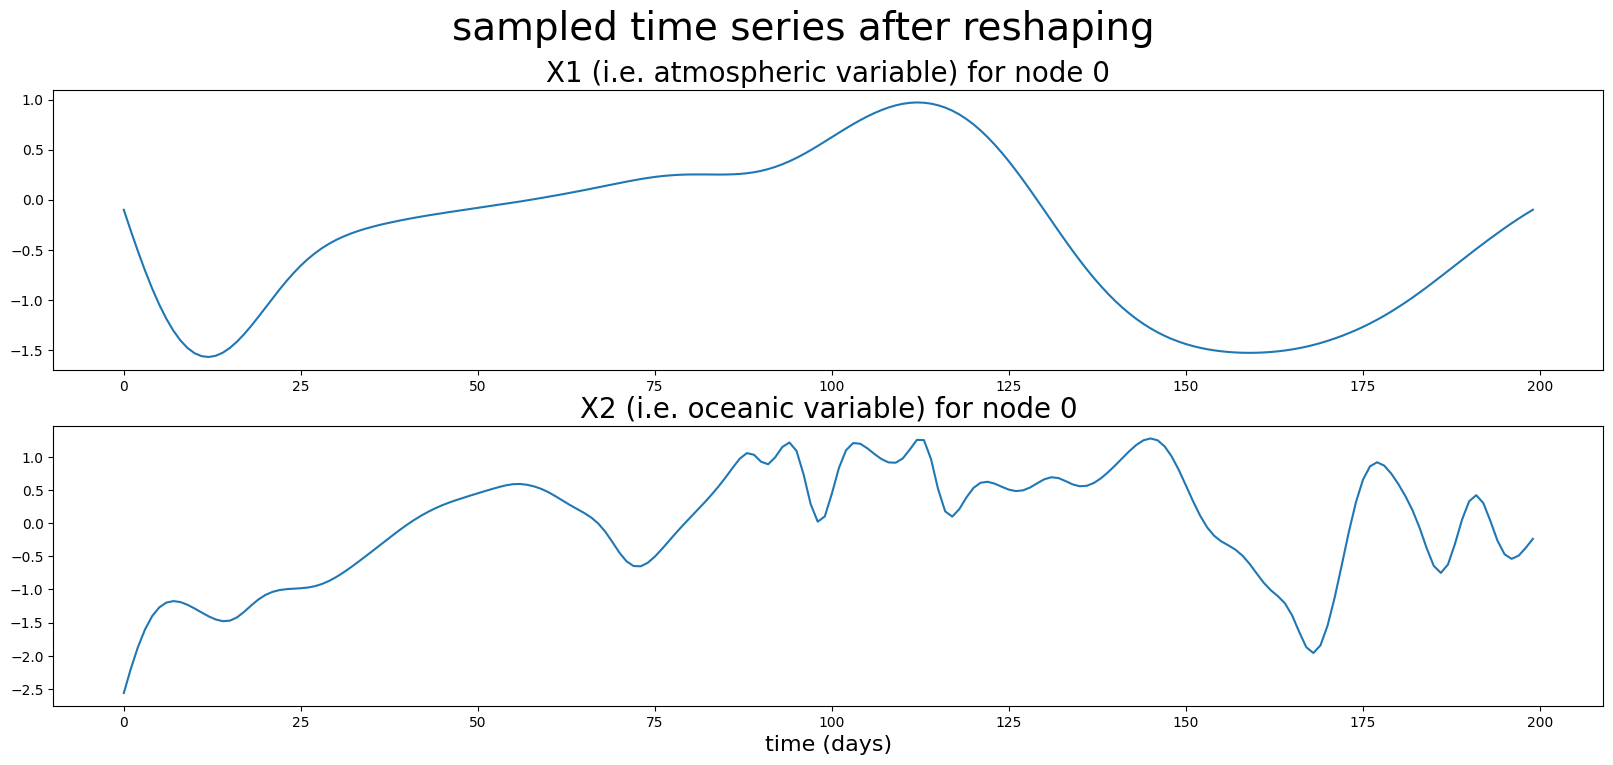

In [43]:
node = 0

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

ax0.plot(lorenz_graph_tuple.nodes[node::36, 0])
ax1.plot(lorenz_graph_tuple.nodes[node::36, 1])

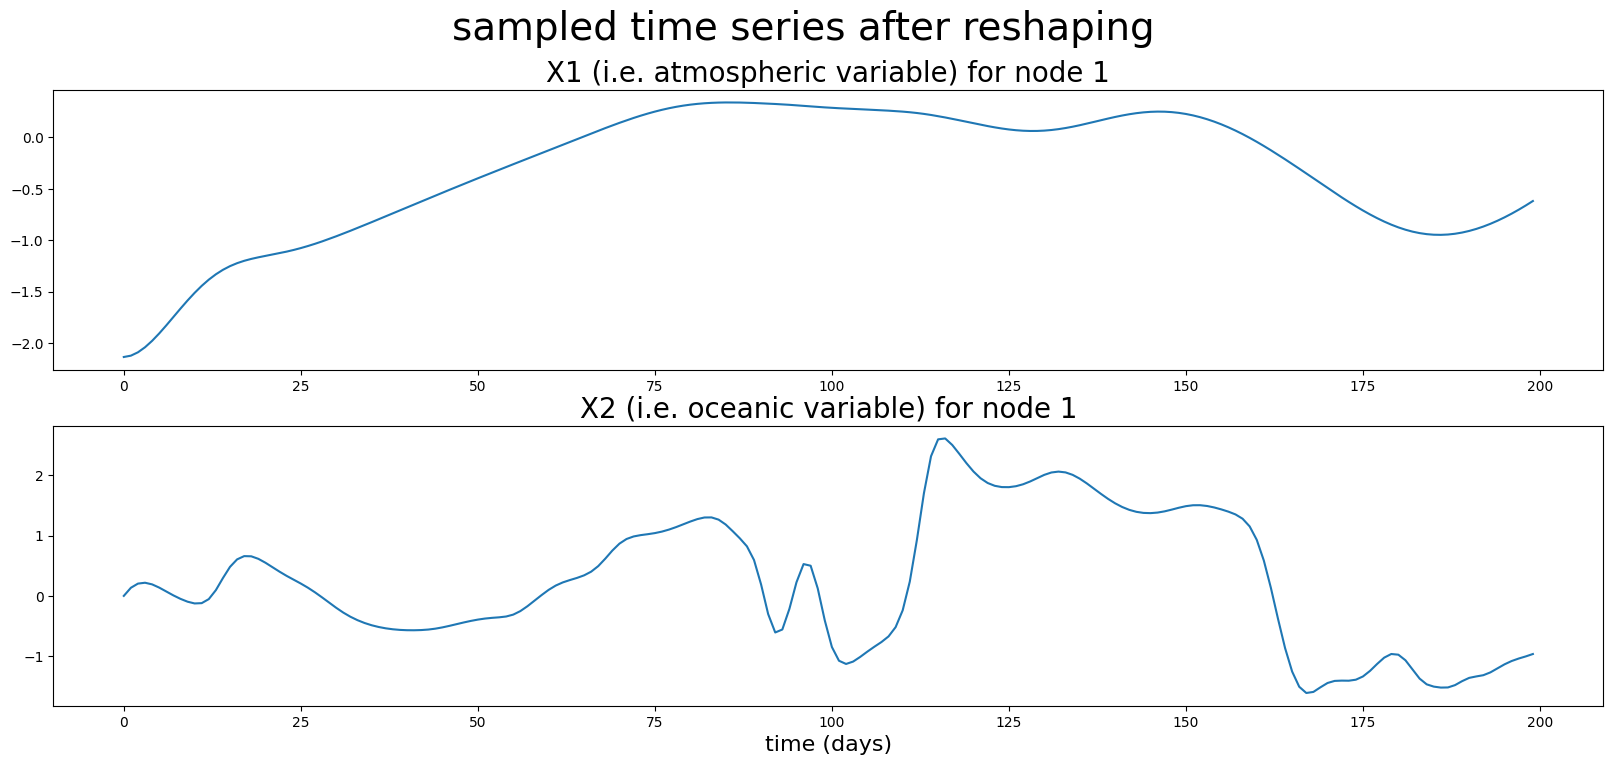

In [44]:
node = 1

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

ax0.plot(lorenz_graph_tuple.nodes[node::36, 0])
ax1.plot(lorenz_graph_tuple.nodes[node::36, 1])

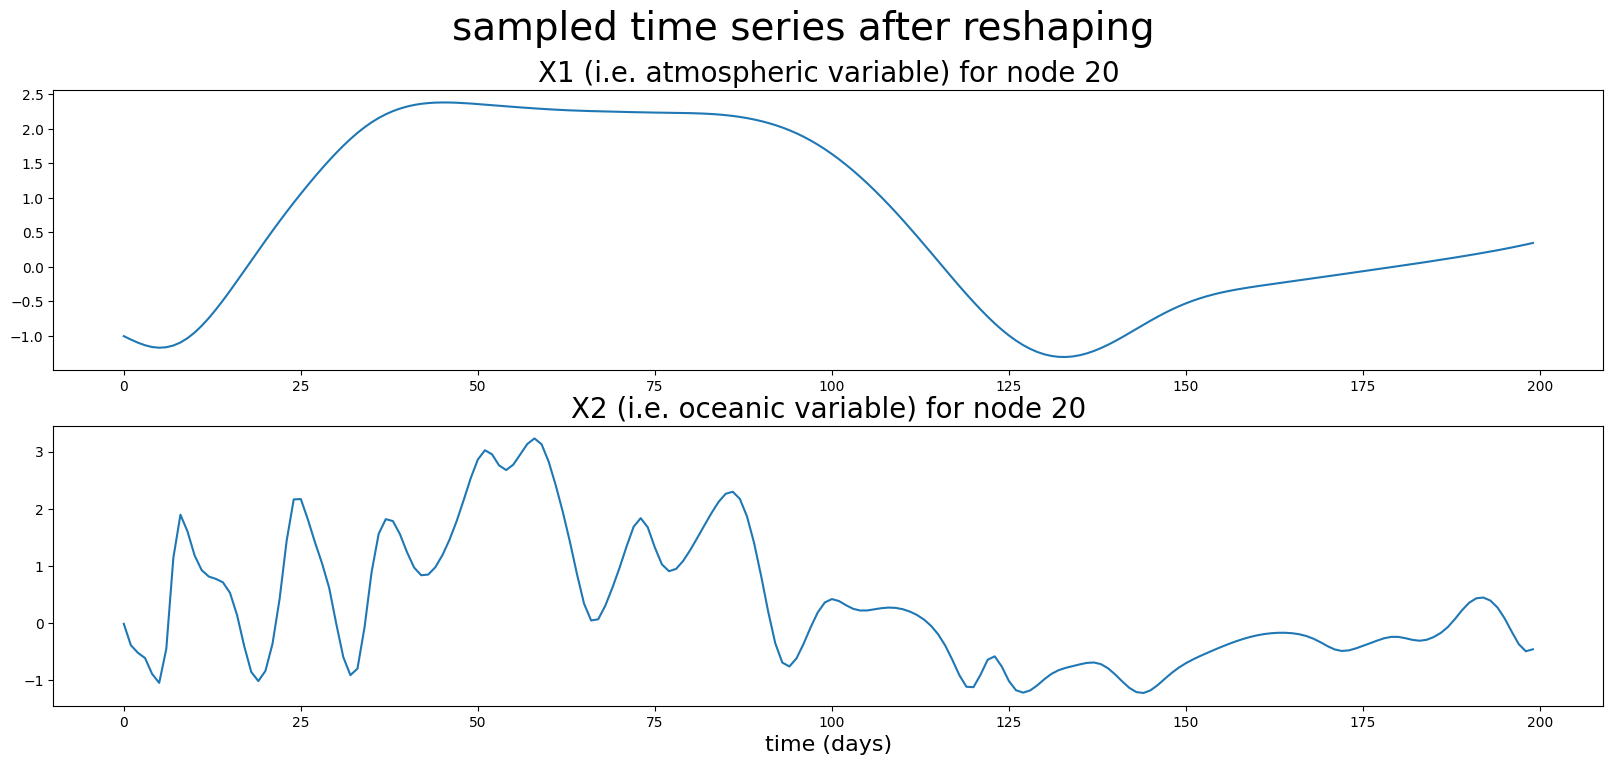

In [45]:
node = 20

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))
fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node),
              size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

ax0.plot(lorenz_graph_tuple.nodes[node::36, 0])
ax1.plot(lorenz_graph_tuple.nodes[node::36, 1])

compare with original spektral dataset

In [46]:
dataset = lorenzDatasetWrapper(
    predict_from="X1X2_window",
    n_samples=200,
    input_steps=1,
    output_delay=0,
    output_steps=0,
    min_buffer=0,
    # rand_buffer=False,
    # K=36,
    # F=8,
    # c=10,
    # b=10,
    # h=1,
    # coupled=True,
    # time_resolution=DEFAULT_TIME_RESOLUTION,
    # seed=42,
    init_buffer_steps=100,
    return_buffer=False,
    train_pct=1,
    val_pct=0,
    test_pct=0,
    override=True)
dataset.normalize()

done computing adj


plotting train
no val data to plot
no training data to plot
editing legend


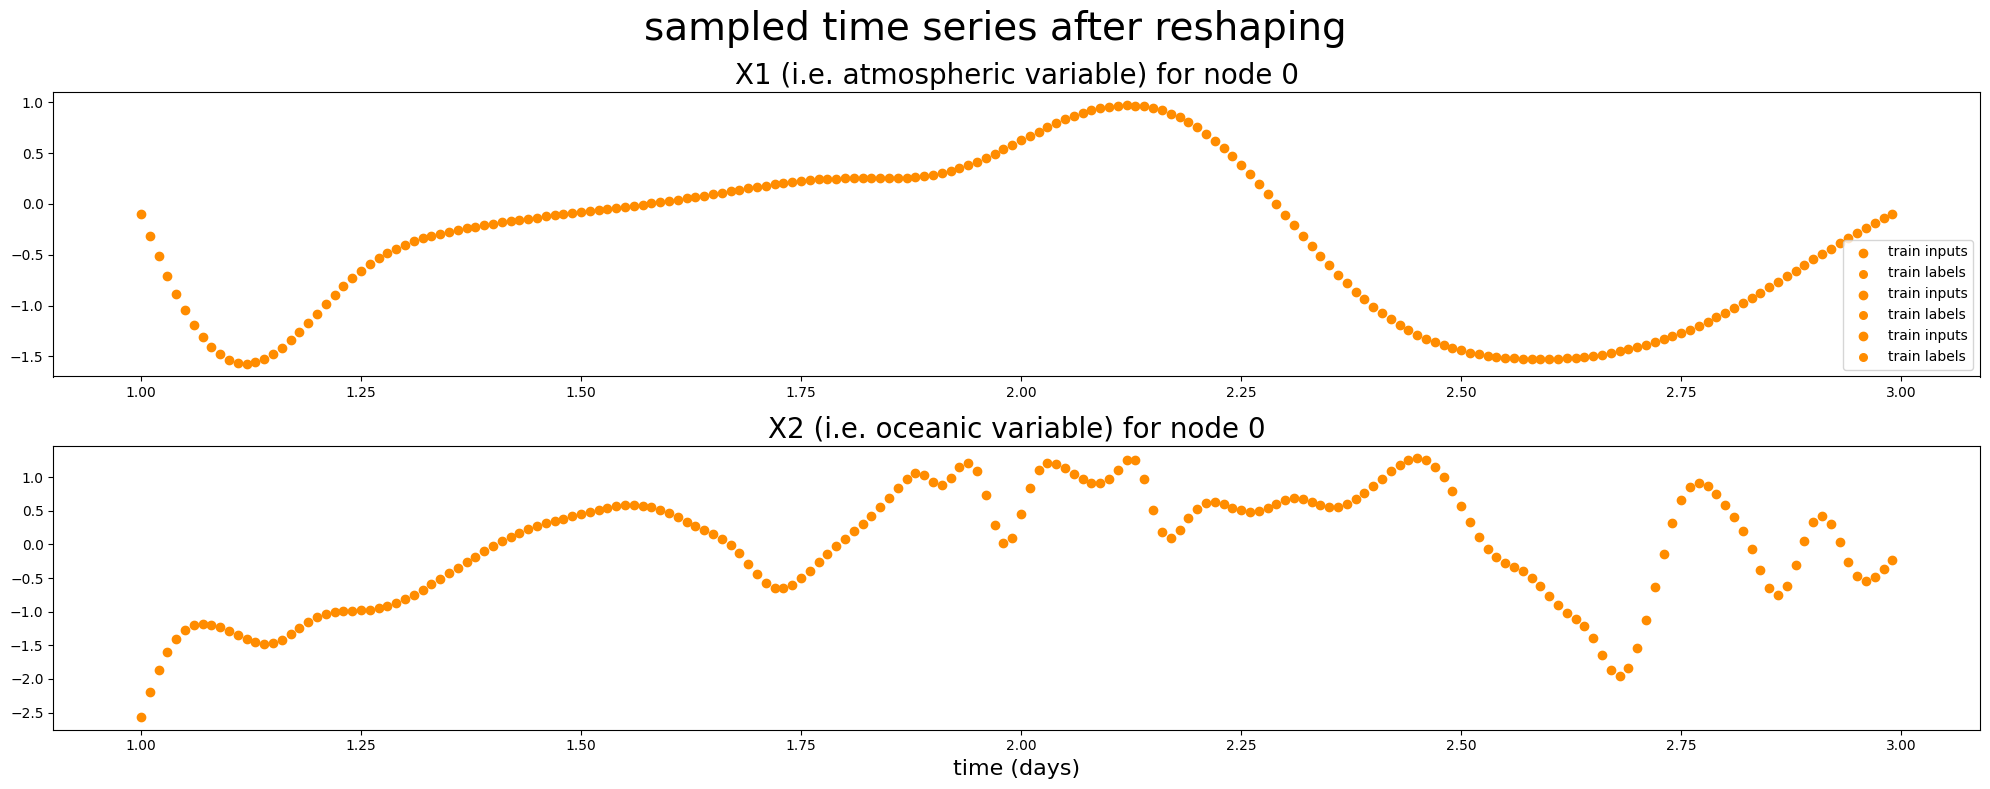

In [47]:
fig, (ax0, ax1) = plot_data(dataset.train, node=0, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


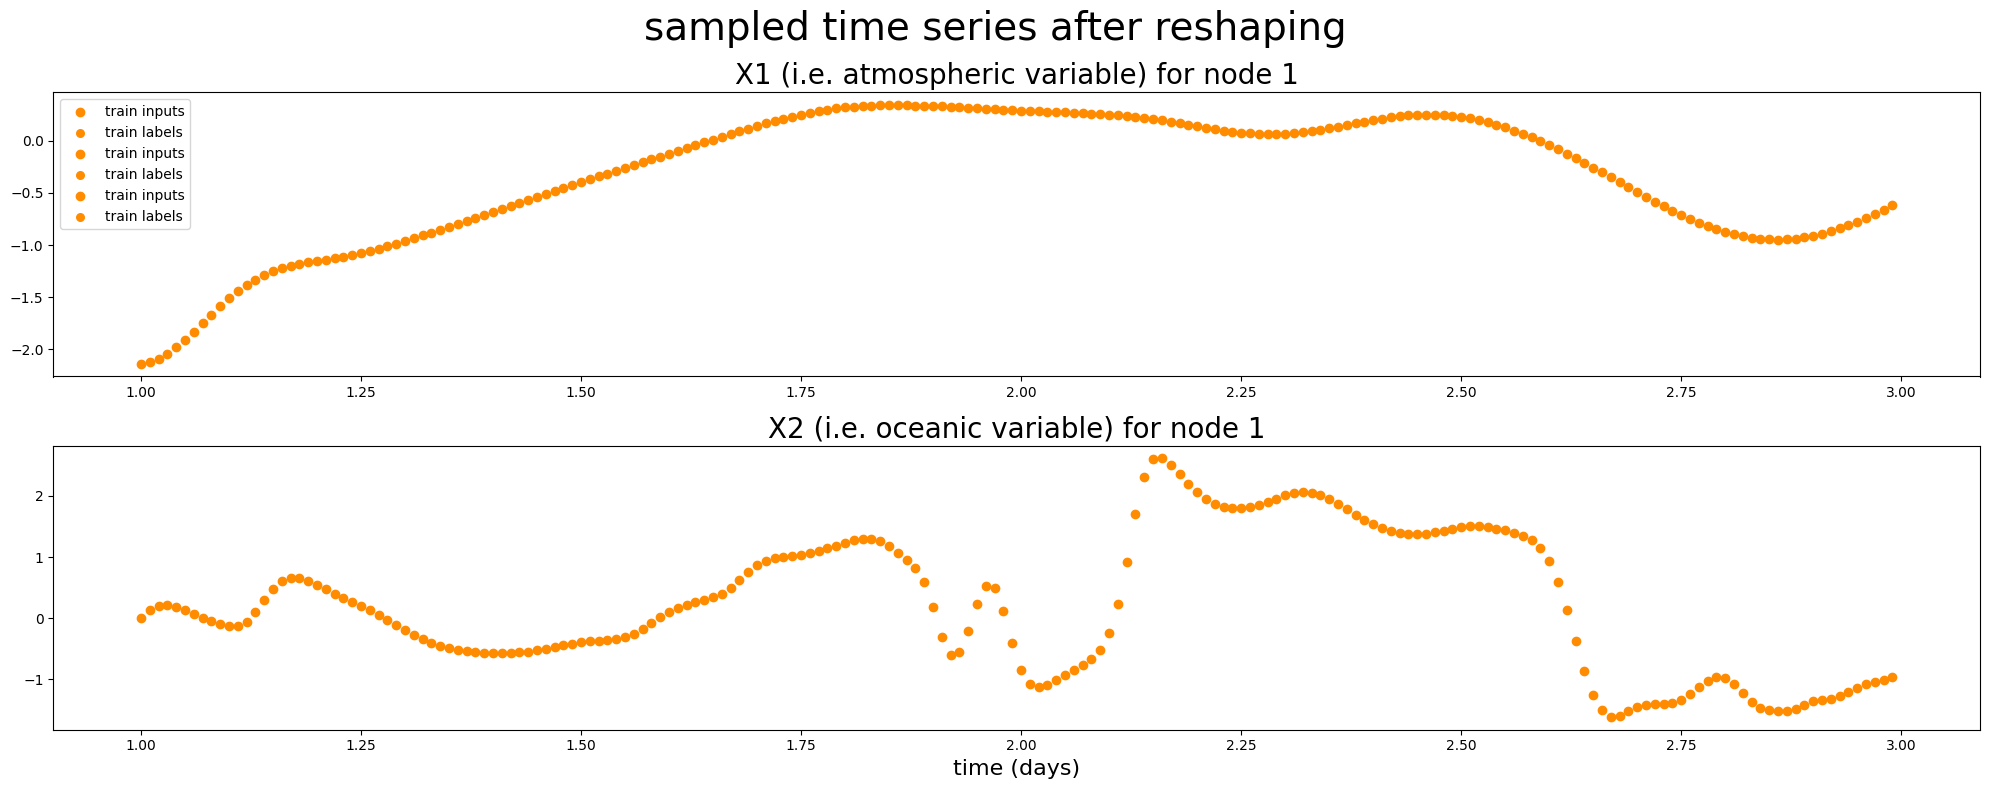

In [48]:
fig, (ax0, ax1) = plot_data(dataset.train, node=1, alpha=1)

plt.tight_layout()
plt.show()

plotting train
no val data to plot
no training data to plot
editing legend


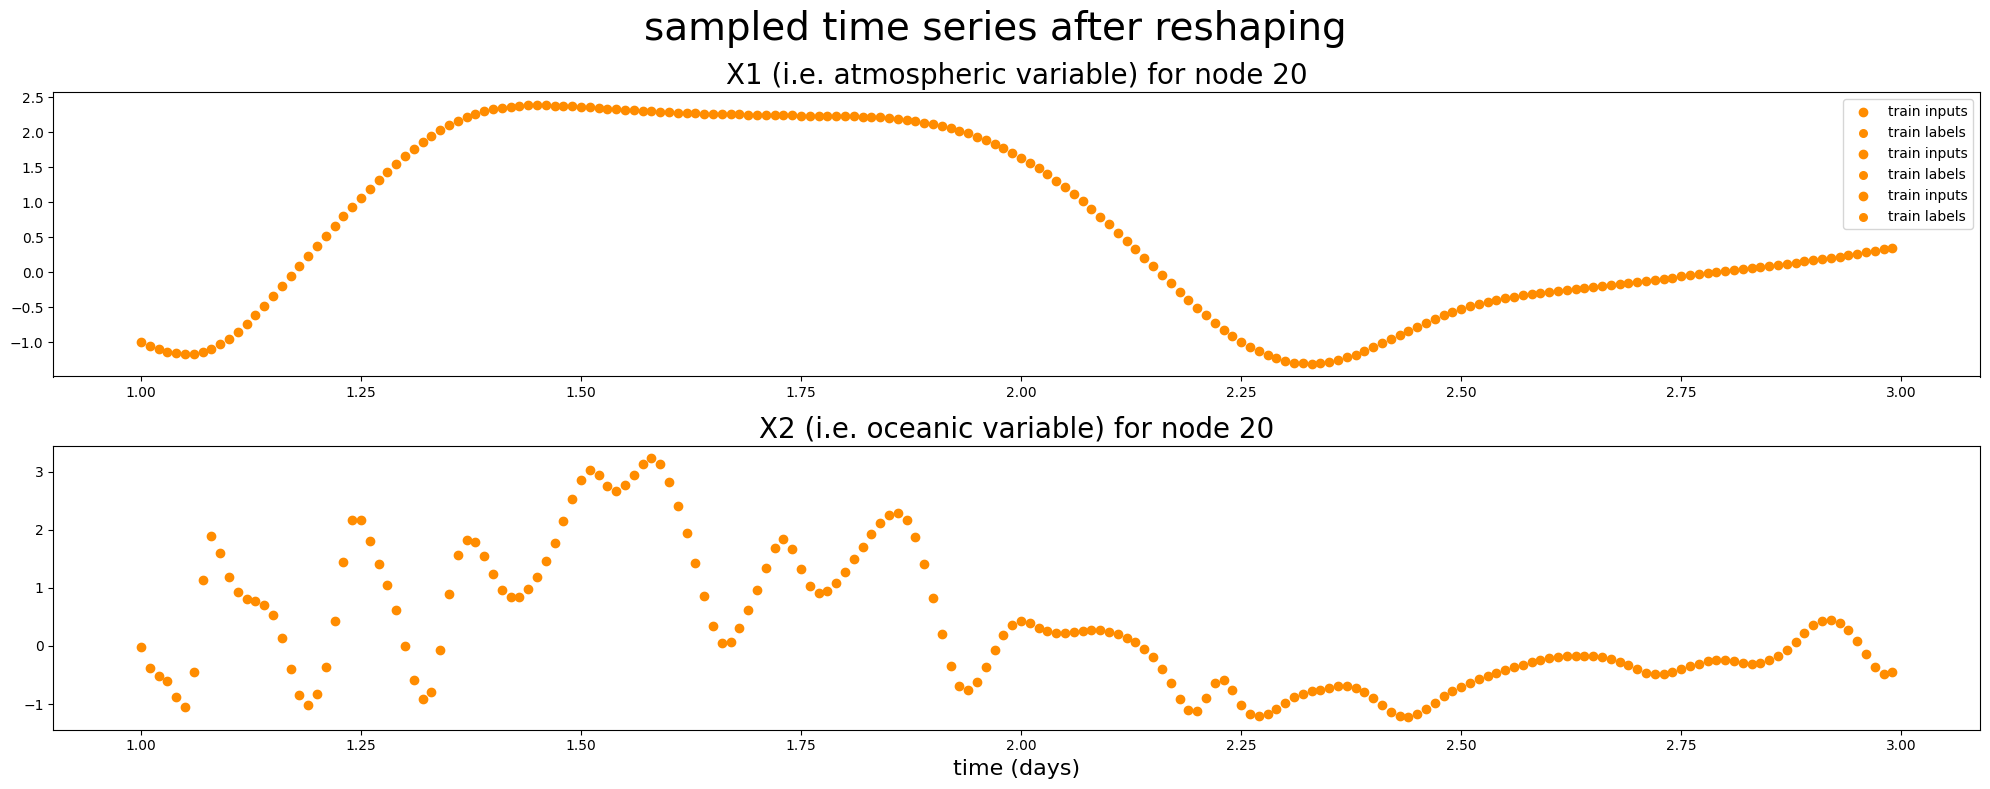

In [49]:
fig, (ax0, ax1) = plot_data(dataset.train, node=20, alpha=1)

plt.tight_layout()
plt.show()

great, the data looks the same. 

### create dataloaders

In [109]:
# slice graphs
first_graph_tf = utils_np.get_graph(lorenz_graph_tuple, 0)
three_graphs_tf = utils_np.get_graph(lorenz_graph_tuple, slice(1, 4))
three_graphs_tf.n_node
type(first_graph_tf)


graph_nets.graphs.GraphsTuple

In [73]:
lorenz_graph_tuple.n_node.shape[0]

200

In [110]:
# TODO make tf Dataset obj? 

def get_data_windows(graph_tuple, n_rollout_steps):
    """ Get inputs and targets from a graph_tuple containing time series data
    
        Args: 
            graph_tuple: a graph tuple object
            n_rollout_steps (int): number of steps for rollout output

        Returns:
            inputs, 1D list of length (timesteps - 2 - n_rollout_steps)
            tragets, 2D list of size (timesteps - 2 - n_rollout_steps, n_rollout_steps)
    """
    inputs = []
    targets = []
    orig_timesteps = graph_tuple.n_node.shape[0]
    n_timesteps = orig_timesteps - 1 - n_rollout_steps

    print(orig_timesteps, n_timesteps)
    for i in range(n_timesteps):
        input_graph = utils_np.get_graph(graph_tuple, i)
        target_graphs = utils_np.get_graph(graph_tuple, slice(i+1, i+1+n_rollout_steps))
        inputs.append(input_graph)
        targets.append(target_graphs)

    # return np.concatenate(inputs, axis=0, dtype=object), np.concatenate(targets, axis=0, dtype=object)
    # return np.vstack(inputs), np.vstack(targets)
    return inputs, targets


### define model

In [51]:
class MLPBlock(snt.Module):
    """ A single GN block with MLP edge, node, and global models.
    
        modified from MLPGraphNetwork in graph_nets.demos_tf2.models
    """

    def __init__(self,
                 edge_mlp_layers,
                 edge_mlp_channels,
                 node_mlp_layers,
                 node_mlp_channels,
                 graph_mlp_layers,
                 graph_mlp_channels,
                 name="MLPBlock"):
        """ Initializes an MLP block. 
        
            Args: 
                *_mlp_layers (int): num layers in the edge/node/graph model
                *_mlp_channels (int): num nodes/channels in each layer of the edge/node/graph model
        """
        super(MLPBlock, self).__init__(name=name)
        self._network = modules.GraphNetwork(
            lambda: make_mlp_model(edge_mlp_layers, edge_mlp_channels),
            lambda: make_mlp_model(node_mlp_layers, node_mlp_channels),
            lambda: make_mlp_model(graph_mlp_layers, graph_mlp_channels))
        # we have to use a lambda bc the init function for each block's function has some fuckery going on
        # acc to the graph_nets_basics notebook: "The reason that a `callable` is provided, instead of the module/method directly, is so the Graph Net object owns the modules and the variables created by them."

    def __call__(self, inputs):
        return self._network(inputs)


def make_mlp_model(n_layers, latent_size, norm_axis=None, layernorm=False):
    """ Instantiates a new MLP, followed by LayerNorm.
        The parameters of each new MLP are not shared with others generated by
        this function.

        Args: 
            n_layers (int): number of MLP layers
            latent_size (int): number of nodes/channels in each layer of the MLP

        Returns:
            A Sonnet module which contains the MLP and LayerNorm.
    """
    if layernorm:
        assert norm_axis is not None
        return snt.Sequential([
            snt.nets.MLP(output_sizes=[latent_size] * n_layers,
                         activate_final=True),
            snt.LayerNorm(axis=norm_axis,
                          create_scale=False,
                          create_offset=False)
        ])
    else:
        return snt.nets.MLP(output_sizes=[latent_size] * n_layers,
                            activate_final=True)


In [52]:
latent_size = 16
n_layers = 3
norm_axis = 1
m = snt.Sequential([
    snt.nets.MLP(output_sizes=[latent_size] * n_layers, activate_final=True),
    snt.LayerNorm(axis=norm_axis, create_scale=False, create_offset=False)
])

m

Sequential(
    layers=[MLP(output_sizes=[16, 16, 16], activate_final=True),
            LayerNorm(axis=1, create_scale=False, create_offset=False)],
)

In [53]:
class MLPGraphNetwork(snt.Module):
    """GraphNetwork consisting of a sequence of MLPBlocks."""

    def __init__(self,
                 n_blocks,
                 recurrent,
                 edge_mlp_layers,
                 edge_mlp_channels,
                 node_mlp_layers,
                 node_mlp_channels,
                 graph_mlp_layers,
                 graph_mlp_channels,
                 name="MLPGraphNetwork"):
        """ Initializes 
        
            Args:
                n_blocks (int): number of MLP blocks
                recurrent (bool): whether or not to share weights btwn blocks
        """
        super(MLPGraphNetwork, self).__init__(name=name)
        self.n_blocks = n_blocks
        self.recurrent = recurrent

        if recurrent:
            self._network = MLPBlock(edge_mlp_layers, edge_mlp_channels,
                                     node_mlp_layers, node_mlp_channels,
                                     graph_mlp_layers, graph_mlp_channels)
        else:
            self._network = snt.Sequential([
                MLPBlock(edge_mlp_layers, edge_mlp_channels, node_mlp_layers,
                         node_mlp_channels, graph_mlp_layers,
                         graph_mlp_channels)
            ] * n_blocks)

    def __call__(self, inputs):
        if self.recurrent:
            # does recurrent need to keep track of internal states? shouldn't we need a gated unit or smth?
            # cause in this sense the ffw can be "recurrent" too e.g. if the core was 9 blocks long but in the rollout we just feed outputs back in to the core autoregressively
            x = inputs
            for _ in self.n_blocks:
                x = self._network(x)
            return x
        else:
            outputs = self._network(inputs)
            return outputs


In [54]:
ffw_network = MLPGraphNetwork(n_blocks=9,
                              recurrent=False,
                              edge_mlp_layers=2,
                              edge_mlp_channels=16,
                              node_mlp_layers=2,
                              node_mlp_channels=16,
                              graph_mlp_layers=2,
                              graph_mlp_channels=16)
# params taken from the graph_net physics demo notebook

In [55]:
ffw_network

MLPGraphNetwork(
    n_blocks=9,
    recurrent=False,
    edge_mlp_layers=2,
    edge_mlp_channels=16,
    node_mlp_layers=2,
    node_mlp_channels=16,
    graph_mlp_layers=2,
    graph_mlp_channels=16,
)

In [56]:
ffw_network._network

Sequential(
    layers=[MLPBlock(
               edge_mlp_layers=2,
               edge_mlp_channels=16,
               node_mlp_layers=2,
               node_mlp_channels=16,
               graph_mlp_layers=2,
               graph_mlp_channels=16,
           ),
            MLPBlock(
               edge_mlp_layers=2,
               edge_mlp_channels=16,
               node_mlp_layers=2,
               node_mlp_channels=16,
               graph_mlp_layers=2,
               graph_mlp_channels=16,
           ),
            MLPBlock(
               edge_mlp_layers=2,
               edge_mlp_channels=16,
               node_mlp_layers=2,
               node_mlp_channels=16,
               graph_mlp_layers=2,
               graph_mlp_channels=16,
           ),
            MLPBlock(
               edge_mlp_layers=2,
               edge_mlp_channels=16,
               node_mlp_layers=2,
               node_mlp_channels=16,
               graph_mlp_layers=2,
               graph_mlp_channels=16

In [57]:
recurrent_network = MLPGraphNetwork(n_blocks=9,
                                    recurrent=True,
                                    edge_mlp_layers=2,
                                    edge_mlp_channels=16,
                                    node_mlp_layers=2,
                                    node_mlp_channels=16,
                                    graph_mlp_layers=2,
                                    graph_mlp_channels=16)
# params taken from the graph_net physics demo notebook

In [58]:
recurrent_network

MLPGraphNetwork(
    n_blocks=9,
    recurrent=True,
    edge_mlp_layers=2,
    edge_mlp_channels=16,
    node_mlp_layers=2,
    node_mlp_channels=16,
    graph_mlp_layers=2,
    graph_mlp_channels=16,
)

In [59]:
recurrent_network._network

MLPBlock(
    edge_mlp_layers=2,
    edge_mlp_channels=16,
    node_mlp_layers=2,
    node_mlp_channels=16,
    graph_mlp_layers=2,
    graph_mlp_channels=16,
)

In [60]:
type(ffw_network)

__main__.MLPGraphNetwork

In [61]:
isinstance(ffw_network, snt.Module)

True

### training helpers

In [62]:
# TODO: check if we need this decorator?
# @tf.function
def rollout(model, inputs, n_steps):
    """ Rolls out a model trajectory.
    
        Modified from https://github.com/deepmind/deepmind-research/blob/master/meshgraphnets/cfd_eval.py
    """
    preds = []
    x = inputs
    for _ in n_steps:
        x = model(x)
        print(type(x))
        print(x.shape)
        preds.append(x)

    return preds

In [63]:
def loss():
    pass


In [64]:
def train_module(epochs):
    pass


### train

In [128]:
inputs, targets = get_data_windows(lorenz_graph_tuple, n_rollout_steps=6)

200 193


In [115]:
targets[0]

GraphsTuple(nodes=array([[-0.31217319, -2.19411463],
       [-2.12316184,  0.13298151],
       [-1.01988128, -1.28226447],
       [-0.99993014, -0.69643079],
       [-0.61680211, -0.75796191],
       [-0.82497841, -0.99818267],
       [ 1.1617384 , -0.97991447],
       [-1.26234266, -0.50733589],
       [-2.18738445, -2.33097779],
       [-3.20782034, -0.06242095],
       [-0.56098138, -0.03981632],
       [-0.24991881,  1.42430692],
       [-2.18502111, -1.52121389],
       [-2.87759783, -1.27119092],
       [-0.67851385,  1.20373394],
       [ 0.77675492,  1.12886124],
       [-2.59460345, -3.31440003],
       [-2.11519185,  0.78959719],
       [ 2.30278423, -1.02494894],
       [ 0.87275261,  1.96015292],
       [-1.05276509, -0.38539741],
       [ 0.94412428,  2.26764615],
       [ 2.82230931,  2.27124227],
       [-1.20460374, -0.95089748],
       [ 0.43093756, -1.21595344],
       [ 2.67611641,  3.82917973],
       [ 1.4893586 ,  0.42574577],
       [-0.66525025, -0.05240332],
  

In [129]:
ffw_network = MLPGraphNetwork(n_blocks=9,
                              recurrent=False,
                              edge_mlp_layers=2,
                              edge_mlp_channels=16,
                              node_mlp_layers=2,
                              node_mlp_channels=16,
                              graph_mlp_layers=2,
                              graph_mlp_channels=16)
inputs, targets = get_data_windows(lorenz_graph_tuple, n_rollout_steps=6)

200 193


In [130]:
lorenz_graph_tuple

GraphsTuple(nodes=array([[-1.00681413e-01, -2.56204442e+00],
       [-2.13611772e+00, -1.87510910e-03],
       [-1.10058598e+00, -1.18880390e+00],
       ...,
       [ 2.52129570e-01,  7.65850419e-01],
       [ 1.00895528e+00,  1.78780991e+00],
       [-8.33438139e-01, -5.84027488e-01]]), edges=array([[ 0],
       [ 1],
       [ 2],
       ...,
       [ 2],
       [-1],
       [-2]]), receivers=array([   0,    1,    2, ..., 7165, 7198, 7197], dtype=int32), senders=array([   0,    0,    0, ..., 7199, 7199, 7199], dtype=int32), globals=array([], shape=(200, 0), dtype=float64), n_node=array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 3

In [134]:
inputs[0].nodes.shape

(36, 2)

In [135]:
(1,2).as_list()

AttributeError: 'tuple' object has no attribute 'as_list'

In [131]:
one_step_bad_pred = ffw_network(inputs[0])

AttributeError: 'tuple' object has no attribute 'as_list'

In [ ]:
lorenz_graph_tuple[0].shape

(7200, 2)

In [ ]:
lorenz_graph_tuple.n_node.shape

(200,)